# Construindo uma RNA para reconhecimento de dígitos

Agora que conhecemos os conceitos teóricos das RNAs, vamos colocá-los em prática, construindo uma RNA para o reconhecimento de dígitos manuscritos e digitalizados.  Por que vamos começar com este tipo de tarefa? Porque ela permite percorrer todas as etapas e procedimentos matemáticos de uma rede neural, sendo portanto uma excelente introdução.

Antes de pensar em escrever sua primeira linha de código, é preciso definir claramente o problema a ser resolvido. A tecnologia existe para resolver problemas e a definição clara do objetivo é o ponto de partida de qualquer projeto de sucesso. Desta forma, vamos começar definindo os dados de entrada do classificador.

Podemos dividir o problema de reconhecer os dígitos manuscritos em dois sub-problemas. Primeiro, precisamos encontrar uma maneira de quebrar uma imagem que contenha muitos dígitos em uma sequência de imagens separadas, cada uma contendo um único dígito. Por exemplo, gostaríamos de quebrar a imagem:

![](rawdigits.png)

Em dígitos individuais, mais ou menos assim:

![](digits_separate.png)

Humanos resolvem esse problema de segmentação com facilidade, mas é um desafio para um programa de computador dividir corretamente a imagem. Uma vez que a imagem foi segmentada, o programa precisa classificar cada dígito individual. Então, por exemplo, gostaríamos que nosso programa reconhecesse automaticamente que o primeiro dígito acima é um 5.

Vamos nos concentrar em escrever um programa para resolver o segundo problema, isto é, classificar dígitos individuais. O problema da segmentação não é tão difícil de resolver, uma vez que você tenha uma boa maneira de classificar os dígitos individuais. Existem muitas abordagens para resolver o problema de segmentação. Uma abordagem é testar muitas maneiras diferentes de segmentar a imagem, usando o classificador de dígitos individuais para marcar cada segmentação de teste. Uma segmentação de teste obtém uma pontuação alta se o classificador de dígitos individuais estiver confiante de sua classificação em todos os segmentos e uma pontuação baixa se o classificador tiver muitos problemas em um ou mais segmentos. A ideia é que, se o classificador estiver tendo problemas em algum lugar, provavelmente está tendo problemas porque a segmentação foi escolhida incorretamente. Essa ideia e outras variações podem ser usadas para resolver o problema de segmentação. Então, em vez de se preocupar com a segmentação, nos concentraremos no desenvolvimento de uma rede neural que pode resolver o problema mais interessante e difícil, ou seja, reconhecer dígitos individuais manuscritos.

Para reconhecer dígitos individuais, usaremos uma rede neural de três camadas. Vamos começar definindo que cada digito será segmentado em uma imagem com $28 \times 28$ pixels, de forma a resultar em um total de $784$ pixels por imagem. Vamos definir nossa camada de entrada mapeando cada pixel, ou seja, teremos 784 neurônios na primeira camada. O valor de entrada de cada neurônio será a cor do pixel correspondente em escala de cinza, devendo variar entre 0.0 e 1.0, onde 0.0 representa a cor branca e 1.0 a cor preta e valores entre estes, gradações de cinza.

Em seguida, adicionaremos uma camada oculta, cujo número de neurônios, chamaremos de $n$. Vamos testar várias configurações de $n$, para observar qual dará o melhor resultado. Vamos definir arbitrariamente o valor $n = 15$, inicialmente.

Finalmente, vamos definir nossa camada de saída. Como temos 10 possíveis dígitos (0 a 9), vamos também usar 10 neurônios na camada de saída. Numeraremos cada neurônio, de forma que, se, por exemplo, o neurônio 3 possua o maior sinal de ativação, significa que o dígito foi reconhecido como um 3 e assim por diante. A definição da quantidade de neurônios de saída não segue uma regra simples, mas é sim baseada em herísticas que foram definidas empiricamente. Por exemplo, podemos pensar que 4 neurônios de saída seriam suficientes para codificar os 10 dígitos, uma vez que $2^4 = 16$. Entretanto, verifica-se que para este caso, uma rede com 10 neurônios de saída aprende melhor do que uma com 4. A justificativa final é empírica: podemos experimentar ambos os projetos de rede, e verifica-se que, para este problema específico, a rede com 10 neurônios de saída aprende a reconhecer dígitos melhor do que a rede com 4 neurônios de saída. Mas isso ainda deixa a pergunta por que o uso de 10 neurônios de saída funciona melhor. Por exemplo, podemos ter certos neurônios na camada oculta ligados ao reconhecimento de partes individuais de cada dígito. A combinação da ativação desses neurônios dá o dígito reconhecido.

A rede resultante terá esta configuração:

![](digits_arch_black.png)

Agora que já temos a arquitetura da rede neural, precisamos definir como será o processo de aprendizagem do algoritmo, antes de começar a codificar.

## Aprendizado com gradiente descendente

A primeira coisa que precisamos é um conjunto de dados para o treinamento da rede. Usaremos o conjunto de dados [MNIST](http://yann.lecun.com/exdb/mnist/), que contém dezenas de milhares de imagens digitalizadas de dígitos manuscritos, juntamente com suas classificações corretas. O nome MNIST vem do fato de que é um subconjunto modificado de dois conjuntos de dados coletados pelo NIST, o Instituto Nacional de Padrões e Tecnologia dos Estados Unidos. Aqui estão algumas imagens do MNIST:

![](digits_separate.png)

Estes dados foram coletados a partir da digitalização de manuscritos de 250 pessoas, metade funcionários do Bureau do Censo dos EUA e metade estudantes do ensino médio. As imagens estão em escala de cinza e 28 por 28 pixels de tamanho. A base está dividida em duas partes, sendo a primeira um conjunto de treinamento com 60k amostras e a segunda um conjunto de teste com 10k amostras. O conjunto de teste é formado por coletas de 250 pessoas diferentes em relação às que participam do conjunto de treinamento. Desta forma, garantimos que a rede consegue reconhecer uma caligrafia que não viu durante o treinamento (que é o que desejamos que ela faça!).

Usaremos a notação x para indicar uma entrada (input) de treinamento. Será conveniente considerar cada entrada de treinamento x (cada imagem) como um vetor de 784 posições (28 x 28 pixels). A imagem abaixo representa como este vetor é construído:

![](pixels.png)

Cada entrada no vetor representa o valor de cinza para um único pixel na imagem. Vamos indicar a saída correspondente desejada por $y = y(x)$, onde $y$ é um vetor com dimensão 10. Por exemplo, se uma imagem de treinamento particular, $x$, representa um 3, então $y(x) = (0,0,0,1,0,0,0,0,0,0)^T$ é a saída desejada da rede . Observe que T aqui é a operação de transposição, transformando um vetor de linha em um vetor comum (coluna).

O que queremos é um algoritmo que nos permita encontrar pesos e bias para que a saída da rede se aproxime de $y(x)$ para todas as entradas de treinamento $x$. Para quantificar o quão bem estamos alcançando esse objetivo, precisamos definir uma função de custo, como esta:

$$
C(w,b) \equiv \frac{1}{2n}\sum^{ }_{x}{\left \| y(x) - a \right \|}^2
$$

Na fórmula acima, $w$ indica a coleta de todos os pesos na rede, $b$ todos os bias (viés), $n$ é o número total de entradas de treinamento, $a$ é o vetor de saídas da rede (quando $x$ é entrada, ou seja o valor desejado) e a soma é sobre todas as entradas de treinamento $x$.

A notação $\left \| v \right \|$ apenas indica a função de comprimento usual para um vetor $v$. Chamaremos $C$ a função de custo quadrático, que também é conhecido como o erro quadrático médio ou apenas o MSE (Mean Squared Error). Inspecionando a forma da função de custo quadrático, vemos que $C (w, b)$ não é negativo, pois cada termo na soma não é negativo. Além disso, o custo $C (w, b)$ torna-se pequeno, isto é, $C (w, b) ≈ 0$, precisamente quando $y(x)$ é aproximadamente igual à saída, a, para todas as entradas de treinamento $x$.

Portanto, nosso algoritmo de treinamento faz um bom trabalho se ele pode encontrar um conjunto de pesos e bias que faça com que $C (w, b) ≈ 0$. Isso significa basicamente que nosso modelo fez as previsões corretas, ou seja, cada vez que apresentamos ao modelo uma imagem com dígito 3, ele é capaz de reconhecer que se trata do número 3.

### O Gradiente Descendente

A maioria das tarefas em Aprendizado de Máquina são na verdade problemas de otimização e um dos algoritmos mais usados para isso é o Algoritmo de Descida do Gradiente (ou Gradiente Descendente). Para um iniciante, o nome Algoritmo de Descida do Gradiente pode parecer intimidante, mas espero que depois de ler o que está logo abaixo, isso deixe de ser um mistério para você.

A Descida do Gradiente é uma ferramenta padrão para otimizar funções complexas iterativamente dentro de um programa de computador. Seu objetivo é: dada alguma função arbitrária, encontrar um mínimo. Para alguns pequenos subconjuntos de funções – aqueles que são convexos – há apenas um único mínimo que também acontece de ser global. Para as funções mais realistas, pode haver muitos mínimos, então a maioria dos mínimos são locais. Certifique-se de que a otimização encontre o “melhor” mínimo e não fique preso em mínimos sub-otimistas (um problema comum durante o treinamento do algoritmo).

Para compreender a intuição da Descida do Gradiente, vamos simplificar um pouco as coisas. Vamos imaginar que simplesmente recebemos uma função de muitas variáveis e queremos minimizar essa função.

Há uma analogia que nos ajuda a compreender como encontrar a solução. Começamos por pensar em nossa função como uma espécie de vale e imaginamos uma bola rolando pela encosta do vale, conforme pode ser visto na figura abaixo. Nossa experiência diária nos diz que a bola acabará rolando para o fundo do vale. Talvez possamos usar essa ideia como forma de encontrar um mínimo para a função? Escolheríamos aleatoriamente um ponto de partida para uma bola (imaginária), e então simularíamos o movimento da bola enquanto ela rola até o fundo do vale. Poderíamos fazer essa simulação simplesmente por derivadas de computação da função C – essas derivadas nos diriam tudo o que precisamos saber sobre a “forma” local do vale, e, portanto, como nossa bola deve rolar.

![](ball.png)

Ou seja, a Descida do Gradiente é um algoritmo de otimização usado para encontrar os valores de parâmetros (coeficientes ou se preferir w e b – weight e bias) de uma função que minimizam uma função de custo. A Descida do Gradiente é melhor usada quando os parâmetros não podem ser calculados analiticamente (por exemplo, usando álgebra linear) e devem ser pesquisados por um algoritmo de otimização.

O procedimento começa com valores iniciais para o coeficiente ou coeficientes da função. Estes poderiam ser 0.0 ou um pequeno valor aleatório (a inicialização dos coeficiente é parte crítica do processo e diversas técnicas podem ser usadas, ficando a escolha a cargo do Cientista de Dados e do problema a ser resolvido com o modelo). Poderíamos iniciar assim nossos coeficientes (valores de w e b):

$$
w = 0.0
$$

O custo dos coeficientes é avaliado ligando-os à função e calculando o custo para uma entrada $x$. 

$$C(x_i) = f(coeficiente)$$

ou

$$C(x_i) = avaliar(f(coeficiente))$$

A derivada do custo é calculada. A derivada é um conceito de Cálculo e refere-se à inclinação da função em um determinado ponto. Precisamos conhecer a inclinação para que possamos conhecer a direção (sinal) para mover os valores dos coeficientes para obter um custo menor na próxima iteração.

$$\delta = \frac{dC(x_i)}{dx_i}$$ 

Agora que sabemos da derivada em que direção está em declive, podemos atualizar os valores dos coeficientes. Um parâmetro de taxa de aprendizagem (eta - $\eta$) deve ser especificado e controla o quanto os coeficientes podem mudar em cada atualização.

$$C(x_i) = coeficiente – (\eta * \delta)$$

Este processo é repetido até que o custo dos coeficientes (função de custo) seja 0.0 ou próximo o suficiente de zero, indicando que as saídas da rede estão cada vez mais próximas dos valores reais (saídas desejadas).

A Descida do Gradiente é simples, mas exige que seja calculado o gradiente da função de custo ou a função que você está otimizando, mas além disso, é muito direto.

### Gradiente descendente em lotes

O objetivo de todos os algoritmos supervisionados de aprendizagem de máquina é estimar uma função de destino (f) que mapeia dados de entrada (X) para as variáveis de saída (Y). Isso descreve todos os problemas de classificação e regressão (aprendizagem supervisionada).

Alguns algoritmos de aprendizagem de máquina têm coeficientes que caracterizam a estimativa de algoritmos para a função alvo (f). Diferentes algoritmos têm diferentes representações e diferentes coeficientes, mas muitos deles requerem um processo de otimização para encontrar o conjunto de coeficientes que resultam na melhor estimativa da função alvo. Os exemplos comuns de algoritmos com coeficientes que podem ser otimizados usando descida do gradiente são Regressão linear e Regressão logística.

A avaliação de quão próximo um modelo de aprendizagem de máquina estima a função de destino pode ser calculada de várias maneiras, muitas vezes específicas para o algoritmo de aprendizagem de máquina. A função de custo envolve a avaliação dos coeficientes no modelo de aprendizagem de máquina calculando uma previsão para o modelo para cada instância de treinamento no conjunto de dados e comparando as previsões com os valores de saída reais e calculando uma soma ou erro médio (como a Soma de Residuais Quadrados ou SSR no caso de regressão linear).

A partir da função de custo, uma derivada pode ser calculada para cada coeficiente para que ele possa ser atualizado usando exatamente a equação de atualização descrita acima.

O custo é calculado para um algoritmo de aprendizado de máquina em todo o conjunto de dados de treinamento para cada iteração do algoritmo de descida de gradiente. Uma iteração do algoritmo é chamada de um lote e esta forma de descida do gradiente é referida como Descida do Gradiente em Lote (Batch Gradient Descent).

A descida do gradiente em lote é a forma mais comum de descida do gradiente em Aprendizado de Máquina.

### Descida do Gradiente Estocástica

A Descida do Gradiente pode ser lenta para executar em conjuntos de dados muito grandes. Como uma iteração do algoritmo de descida do gradiente requer uma previsão para cada instância no conjunto de dados de treinamento, pode demorar muito quando você tem muitos milhões de instâncias.

Em situações em que você possui grandes quantidades de dados, você pode usar uma variação da descida do gradiente chamada Stochastic Gradient Descent.

Nesta variação, o procedimento de descida do gradiente descrito acima é executado, mas a atualização para os coeficientes é realizada para cada instância de treinamento, em vez do final do lote de instâncias.

O primeiro passo do procedimento exige que a ordem do conjunto de dados de treinamento seja randomizada. Isto é, misturar a ordem que as atualizações são feitas para os coeficientes. Como os coeficientes são atualizados após cada instância de treinamento, as atualizações serão ruidosas, saltando por todo o lado, e assim o custo correspondente funcionará. Ao misturar a ordem para as atualizações dos coeficientes, ela aproveita essa caminhada aleatória e evita que ela fique “distraída” ou presa em um mínimo local.

O procedimento de atualização para os coeficientes é o mesmo que o anterior, exceto que o custo não é somado em todos os padrões de treinamento, mas sim calculado para um padrão de treinamento.

A aprendizagem pode ser muito mais rápida com descida de gradiente estocástica para conjuntos de dados de treinamento muito grandes e muitas vezes você só precisa de um pequeno número de passagens através do conjunto de dados para alcançar um conjunto de coeficientes bom o suficiente.

# Implementação em Python

Depois de toda essa teoria, é hora de ver na prática! Como citamos anteriormente, usaremos a bade de dados MNIST de dígitos nesse exercício. A base contém 60k imagens de treinamento e 10k imagens de teste. Podemos usá-la como está, mas vamos fazer nosso processo de forma um pouco diferente. Vamos dividir as 60k imagens de treinamento em um conjunto de 50k de treino e 10k para validação, que usaremos para validar o resultado e afinar outros parâmetros da rede, como a taxa de aprendizagem.

Vamos utilizar o Numpy para lidar com os valores. Comecemos definindo a classe RedeNeural:

In [13]:
import numpy as np
import random

class RedeNeural:
    def __init__(self, tamanhos):
        self.ncamadas = len(tamanhos)
        self.tamanhos = tamanhos
        self.bias  = [np.random.randn(y, 1) for y in tamanhos[1:]]
        self.pesos = [np.random.randn(y, x) for x, y in zip(tamanhos[:-1], tamanhos[1:])]

Neste código, o parâmetro *tamanhos* contêm o número de neurônios nas respectivas camadas, sendo um objeto do tipo lista em Python. Então, por exemplo, se queremos criar um objeto da classe RedeNeural com 2 neurônios na primeira camada, 3 neurônios na segunda camada e 1 neurônio na camada final, aqui está o código que usamos para instanciar um objeto da classe

$$rede = RedeNeural([2,3,1])$$

In [2]:
rede = RedeNeural([2,3,1])
print("Bias: ", rede.bias)
print("Pesos: ", rede.pesos)

Bias:  [array([[-1.12295494],
       [-1.63789129],
       [-0.1914761 ]]), array([[-0.58033393]])]
Pesos:  [array([[2.06608469, 0.47819627],
       [0.04202737, 0.05670925],
       [0.2004814 , 1.27357825]]), array([[ 1.58789921, -0.08455679,  0.09899815]])]


Os pesos e bias são inicializados aleatoriamente, usando a função *np.random.randn*, que gera números com distribuição gaussiana com média 0 e desvio padrão 1. Usaremos o algoritmo de descida de gradiente estocástico, usando esse chute inicial aleatório. Observe que a primeira camada não faz nenhuma computação, então não tem nenhum valor de bias.

Agora, vamos definir a função de ativação da rede. Usaremos a função sigmoide:

In [14]:
    def sigmoide(self, z):
        return 1./(1. + np.exp(-z))

Observe que quando a entrada z é um vetor ou uma matriz Numpy, Numpy aplica automaticamente a função sigmoid elementwise, ou seja, na forma vetorizada.

Em seguida, adicionamos um método feedforward à classe Network, que, dada a entrada a para a rede, retorna a saída corresponente. Basicamente o método feedforward aplica a Equação 1 mostrada acima, para cada camada:

In [4]:
    def feedForward(self, a):
        for b, w in zip(self.bias, self.pesos):
            a = self.sigmoide(np.dot(w, a)+b)
        return a

A principal atividade que queremos que nossos objetos da classe Network façam é aprender. Para esse fim, criaremos um método SGD (Stochastic Gradient Descent). Aqui está o código. É um pouco misterioso em alguns lugares, mas vamos explicar em detalhes mais abaixo:

In [5]:
    def SGD(self, treino, epocas, tamanho_lote, eta, teste=None):
        treino = list(treino)
        n = len(treino)
        
        if teste:
            teste = list(teste)
            n_teste = len(teste)
        
        for j in range(epocas):
            random.shuffle(treino)
            lotes = [treino[k:k+tamanho_lote] for k in range(0, n, tamanho_lote)]
            
            for lote in lotes:
                self.atualiza_lote(lote, eta)
                
            if teste:
                print("Época {} : {}/{}".format(j, self.avalia(teste), n_teste));
            else:
                print("Época {} finalizada".format(j))

O parâmetro *treino* é uma lista de tuplas (x, y) que representam as entradas de treinamento e as correspondentes saídas desejadas. As variáveis *epocas* e *tamanho_lote* são o que você esperaria – o número de épocas para treinar e o tamanho dos mini-lotes a serem usados durante a amostragem, enquanto *eta* é a taxa de aprendizagem, η. Se o argumento opcional *teste* for fornecido, o programa avaliará a rede após cada período de treinamento e imprimirá o progresso parcial. Isso é útil para rastrear o progresso, mas retarda substancialmente as coisas.

O código funciona da seguinte forma. Em cada época, ele começa arrastando aleatoriamente os dados de treinamento e, em seguida, particiona-os em mini-lotes de tamanho apropriado. Esta é uma maneira fácil de amostragem aleatória dos dados de treinamento. Então, para cada lote, aplicamos um único passo de descida do gradiente. Isso é feito pelo código *self.atualiza_lote(lote, eta)*, que atualiza os pesos e os bias da rede de acordo com uma única iteração de descida de gradiente, usando apenas os dados de treinamento em mini-lotes. Aqui está o código para o método atualiza_lote:

In [6]:
    def atualiza_lote(self, lote, eta):
        nabla_b = [np.zeros(b.shape) for b in self.bias]
        nabla_w = [np.zeros(w.shape) for w in self.pesos]
        
        for x, y in lote:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
            
        self.pesos = [w-(eta/len(lote))*nw for w, nw in zip(self.pesos, nabla_w)]
        self.bias  = [b-(eta/len(lote))*nb for b, nb in zip(self.bias, nabla_b)]

A maior parte do trabalho é feita pela linha delta_nabla_b, delta_nabla_w = self.backprop (x, y). Isso invoca o algoritmo de backpropagation, que é uma maneira rápida de calcular o gradiente da função de custo. Portanto, *atualiza_lote* funciona simplesmente calculando esses gradientes para cada exemplo de treinamento no lote e, em seguida, atualizando *self.pesos* e *self.biases* adequadamente.

Abaixo você encontra o código para *self.backprop*, mas não o estudaremos agora. Estudaremos em detalhes como funciona o backpropagation futuramente. Por hora, basta assumir que ele se comporta conforme indicado, retornando o gradiente apropriado para o custo associado ao exemplo de treinamento *x*.

In [7]:
    def backprop(self, x, y):
        nabla_b = [np.zeros(b.shape) for b in self.bias]
        nabla_w = [np.zeros(w.shape) for w in self.pesos]
        
        # Feedforward
        ativacao = x
        
        # Lista para armazenar todas as ativações, camada por camada
        ativacoes = [x]
        
        # Lista par armazenar todos os vetores z, camada por camada
        zs = []
        
        for b, w in zip(self.bias, self.pesos):
            z = np.dot(w, ativacao) + b
            zs.append(z)
            ativacao = self.sigmoide(z)
            ativacoes.append(ativacao)
        
        # Backward pass
        delta = self.derivada_custo(ativacoes[-1], y) * self.sigmoide_prim(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, ativacoes[-2].transpose())
        
        for l in range(2, self.ncamadas):
            z = zs[-l]
            sp = self.sigmoide_prim(z)
            delta = np.dot(self.pesos[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, ativacoes[-l+1].transpose()) # Esta linha estava errada
        return (nabla_b, nabla_w)

A classe **RedeNeural** é em essência nosso algoritmo de rede neural. A partir dela criamos uma instância (como rede), alimentamos com os dados de treinamento e realizamos o treinamento. Avaliamos então a performance da rede com dados de teste e repetimos todo o processo até alcançar o nível de acurácia desejado em nosso projeto. Quando o modelo final estiver pronto, usamos para realizar as previsões para as quais o modelo foi criado, apresentando a ele novos conjuntos de dados e extraindo as previsões. Perceba que este é um algoritmo de rede neural bem simples, mas que permite compreender como funcionam as redes neurais e mais tarde,  as redes neurais profundas ou Deep Learning.

Para finalizar, vamos adicionar um método para retornar a derivada da sigmóide e os métodos *avalia* e *derivada_custo*.

In [8]:
    def avalia(self, teste):
        resultado_teste = [(np.argmax(self.feedForward(x)), y) for (x, y) in teste]
        return sum(int(x == y) for (x, y) in resultado_teste)

    def derivada_custo(self, output_activations, y):
        return (output_activations-y)

Abaixo, o código completo da classe RedeNeural:

In [15]:
import numpy as np
import random

class RedeNeural:
    def __init__(self, tamanhos):
        self.ncamadas = len(tamanhos)
        self.tamanhos = tamanhos
        self.bias  = [np.random.randn(y, 1) for y in tamanhos[1:]]
        self.pesos = [np.random.randn(y, x) for x, y in zip(tamanhos[:-1], tamanhos[1:])]
    
    def sigmoide(self, z):
        return 1./(1. + np.exp(-z))
    
    def sigmoide_prim(self, z):
        return self.sigmoide(z)*(1-self.sigmoide(z))
    
    def feedForward(self, a):
        for b, w in zip(self.bias, self.pesos):
            a = self.sigmoide(np.dot(w, a) + b)
        return a
    
    def SGD(self, treino, epocas, tamanho_lote, eta, teste=None):
        #import ipdb; ipdb.set_trace()
        treino = list(treino)
        n = len(treino)
        
        if teste:
            teste = list(teste)
            n_teste = len(teste)
        
        for j in range(epocas):
            random.shuffle(treino)
            lotes = [treino[k:k+tamanho_lote] for k in range(0, n, tamanho_lote)]
            
            for lote in lotes:
                self.atualiza_lote(lote, eta)
                
            if teste:
                print("Época {} : {}/{}".format(j, self.avalia(teste), n_teste));
            else:
                print("Época {} finalizada".format(j))
                
    def atualiza_lote(self, lote, eta):
        nabla_b = [np.zeros(b.shape) for b in self.bias]
        nabla_w = [np.zeros(w.shape) for w in self.pesos]
        
        for x, y in lote:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
            
        self.pesos = [w-(eta/len(lote))*nw for w, nw in zip(self.pesos, nabla_w)]
        self.bias  = [b-(eta/len(lote))*nb for b, nb in zip(self.bias, nabla_b)]
        
    def backprop(self, x, y):
        nabla_b = [np.zeros(b.shape) for b in self.bias]
        nabla_w = [np.zeros(w.shape) for w in self.pesos]
        
        # Feedforward
        ativacao = x
        
        # Lista para armazenar todas as ativações, camada por camada
        ativacoes = [x]
        
        # Lista par armazenar todos os vetores z, camada por camada
        zs = []
        
        for b, w in zip(self.bias, self.pesos):
            z = np.dot(w, ativacao) + b
            zs.append(z)
            ativacao = self.sigmoide(z)
            ativacoes.append(ativacao)
        
        # Backward pass
        delta = self.derivada_custo(ativacoes[-1], y) * self.sigmoide_prim(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, ativacoes[-2].transpose())
        
        for l in range(2, self.ncamadas):
            z = zs[-l]
            sp = self.sigmoide_prim(z)
            delta = np.dot(self.pesos[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, ativacoes[-l-1].transpose())
        return (nabla_b, nabla_w)
    
    def avalia(self, teste):
        resultado_teste = [(np.argmax(self.feedForward(x)), y) for (x, y) in teste]
        return sum(int(x == y) for (x, y) in resultado_teste)

    def derivada_custo(self, output_activations, y):
        return (output_activations-y)

Agora, vamos carregar os dados de treinamento, que estão no diretório **data**. Vamos também construir algumas funções auxiliares, para prepará-los no formato que nossa rede aceita.

In [16]:
# Carregar o dataset MNIST

# Imports
import pickle
import gzip
import numpy as np

def load_data():
    f = gzip.open('data/mnist.pkl.gz', 'rb')
    training_data, validation_data, test_data = pickle.load(f, encoding="latin1")
    f.close()
    return (training_data, validation_data, test_data)

def load_data_wrapper():
    tr_d, va_d, te_d = load_data()
    training_inputs = [np.reshape(x, (784, 1)) for x in tr_d[0]]
    training_results = [vectorized_result(y) for y in tr_d[1]]
    training_data = list(zip(training_inputs, training_results))
    validation_inputs = [np.reshape(x, (784, 1)) for x in va_d[0]]
    validation_data = list(zip(validation_inputs, va_d[1]))
    test_inputs = [np.reshape(x, (784, 1)) for x in te_d[0]]
    test_data = list(zip(test_inputs, te_d[1]))
    return (training_data, validation_data, test_data)

def vectorized_result(j):
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

Vamos agora dividir nosso conjunto de dados em três partes, um conjunto de treinamento, um de validação e um de teste. Vamos olhar o formato do primeiro elemento, para ver se está da mesma forma que necessitamos.

In [17]:
treino, valida, teste = load_data_wrapper()
treino[0][0].shape

(784, 1)

Se quisermos visualizar os dados, podemos utilizar a biblioteca Matplotlib para isso.

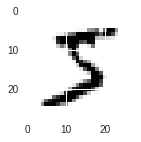

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
plt.figure(figsize=(2,2));
m = treino[0][0].reshape((28,28))
plt.imshow(m);

def prev_to_img(ind):
    plt.figure(figsize=(2,2));
    m = teste[ind][0].reshape((28,28))
    plt.imshow(m);

Chegou o momento! Vamos construir uma nova rede com as configurações que determinamos no projeto e treiná-la por 100 épocas. Hora de um pouco de paciência...

In [ ]:
# Uma tupla com o número de neurônios em cada camada.
# O número de camadas é igual ao número de elementos da tupla.
rede = RedeNeural((784,28,14,7,10))
#SGD(self, treino, epocas, tamanho_lote, eta, teste=None):
rede.SGD(treino, 10, 100, 0.3)

Época 0 finalizada


Bom! Agora, podemos testar o desempenho usando nosso conjunto de teste. Vamos limitar o número de casas decimais em 2, para ficar mais fácil de observar. Não se preocupe, é apenas para exibição. O Numpy armazena o número completo, portanto, não há perda de precisão.

[[0.  ]
 [0.16]
 [0.04]
 [0.32]
 [0.01]
 [0.07]
 [0.  ]
 [0.01]
 [0.28]
 [0.11]]
Previsão: 3
Real:


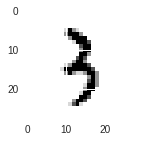

In [23]:
# Este comando configura a exibição para duas casas decimais
np.set_printoptions(precision=2, suppress=True)
# Índice da amostra a testar
ind = 2348
# Apresentando uma amostra à rede e capturando a previsão
res = rede.feedForward(teste[ind][0])
print(res)

# Mostrando a amostra original
prev_to_img(ind)
print("Previsão: {}".format(np.argmax(res)))
print("Real:")

Será que nossa rede está com bom desempenho? Uma das técnicas mais usadas para aferir a qualidade de um classificador é a Matriz de Confusão. Nesta matriz, confrontamos o valor esperado nas linhas com o valor previsto pelo classificador nas colunas. Na diagonal principal, ficam todos os acertos, ou seja, todas as vezes que nosso classificador acertou o dígito. Fora das diagonais, ficam os erros.

In [25]:
confMat = np.zeros((10,10), dtype=int)
for t in treino:
    prev = np.argmax(rede.feedForward(t[0]))
    espr = np.argmax(t[1])
    confMat[espr][prev] += 1;
print(confMat)

[[4551    0   84   14   27   66   88   44   50    8]
 [   1 5414   90   27   17   17   34   32   39    7]
 [ 161  104 3772  115  112   20  248  149  252   35]
 [ 141  127  613 2156  223  681  190  218  608  144]
 [  40   76  239  130 3210   95  231   86  147  605]
 [ 208  139  121  264  172 2744  404   69  253  132]
 [  76   57  177   49   75   95 4348   19   50    5]
 [  39   91   79  114  150   74   13 4328   63  224]
 [  73  177  180  646  103  279  117   66 3058  143]
 [  67   50   69  275  726  102   23  339  112 3225]]


Por fim, vamos calcular um indicador chamado acurácia. A acurácia permite um vislumbre rápido do desempenho do classificador, pois mostra a razão entre o número de acertos e o número total de amostras. Mais cuidado! Apenas a acurácia não permite visualizar corretamente o desempenho do classificador! Outras métricas devem ser usadas em conjunto com ela, para termos uma visão mais completa. Veja a figura. O estudo dessas métricas fica como exercício ;-)

![](acc_prec.png)

Vamos construir uma função que imprime um relatório com a acurácia calculada para cada classe:

In [26]:
def relatorio(confMat):
    l = confMat.shape[0]
    accPorClasse = []
    for i in range(l):
        tp = confMat[i][i]
        fp = np.sum(confMat, axis=1)[i] - tp
        fn = np.sum(confMat, axis=0)[i] - tp
        tn = np.sum(confMat) - tp - fp - fn
        accPorClasse.append((tp+tn)/(tp+tn+fp+fn))
    print(f"Relatório de métricas:")
    accAvg = np.average(accPorClasse)
    print("Acurácia média: "+f"{0:4.2f}".format(accAvg))
    print(f"Acurácia por Classe:")
    for i, v in enumerate(accPorClasse):
        print("Classe {0:2d}: ".format(i)+"{0:4.4f}".format(v))
        
relatorio(confMat)

Relatório de métricas:
Acurácia média: 0.00
Acurácia por Classe:
Classe  0: 0.9763
Classe  1: 0.9783
Classe  2: 0.9430
Classe  3: 0.9084
Classe  4: 0.9349
Classe  5: 0.9362
Classe  6: 0.9610
Classe  7: 0.9626
Classe  8: 0.9328
Classe  9: 0.9387
